# ML Zoomcamp 2023 – Second Capstone Project

[Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs)

In [17]:
import tarfile
import urllib.request
import os
import re
from pandas import Series
from pathlib import Path
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from sklearn.model_selection import train_test_split
from time import time

In [2]:
images_url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
annotations_url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar'
images_dir = 'data/raw/Images'
annotation_dir = 'data/raw/Annotation'

In [3]:
plt.style.use('barplot-style.mplstyle')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Download data

In [4]:
def download_data(url):
    basename = os.path.basename(url)
    raw_data_dir = Path.cwd() / 'data/raw'
    raw_data_file = raw_data_dir / basename
    if not raw_data_file.is_file():
        raw_data_dir.mkdir(parents=True, exist_ok=True)
        print(f'Downloading {basename}...')
        urllib.request.urlretrieve(url, raw_data_file)
        with tarfile.open(raw_data_file) as data_tarball:
            data_tarball.extractall(path=raw_data_dir)
    Path.unlink(raw_data_file)
    print(f'Finished downloading and extracting {basename}.')

In [5]:
if not Path(images_dir).exists():
    download_data(images_url)

In [6]:
if not Path(annotation_dir).exists():
    download_data(annotations_url)

## Exploratory data analysis

In [7]:
breed_dir_list = [name for name in os.listdir(images_dir) if name not in ['.DS_Store']]
breed_dict = {}
for breed_dir in breed_dir_list:
    full_breed_dir = Path.cwd() / images_dir / breed_dir
    breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
    breed_name = re.sub(r'-', r'_', breed_name.lower())
    breed_dict[breed_name] = len(list(full_breed_dir.glob('**/*.jpg')))

In [8]:
breed_sr = Series(breed_dict)
breed_sr.sort_values(ascending=False, inplace=True)
breed_sr.head(20)

maltese_dog             252
afghan_hound            239
scottish_deerhound      232
pomeranian              219
bernese_mountain_dog    218
samoyed                 218
irish_wolfhound         218
shih_tzu                214
great_pyrenees          213
leonberg                210
basenji                 209
tibetan_terrier         206
entlebucher             202
sealyham_terrier        202
airedale                202
pug                     200
saluki                  200
lakeland_terrier        197
cairn                   197
papillon                196
dtype: int64

In [9]:
top_num = 10
top_index_names = breed_sr.index[:top_num]
custom_labels = [' '.join(col.split('_')).capitalize() for col in top_index_names]

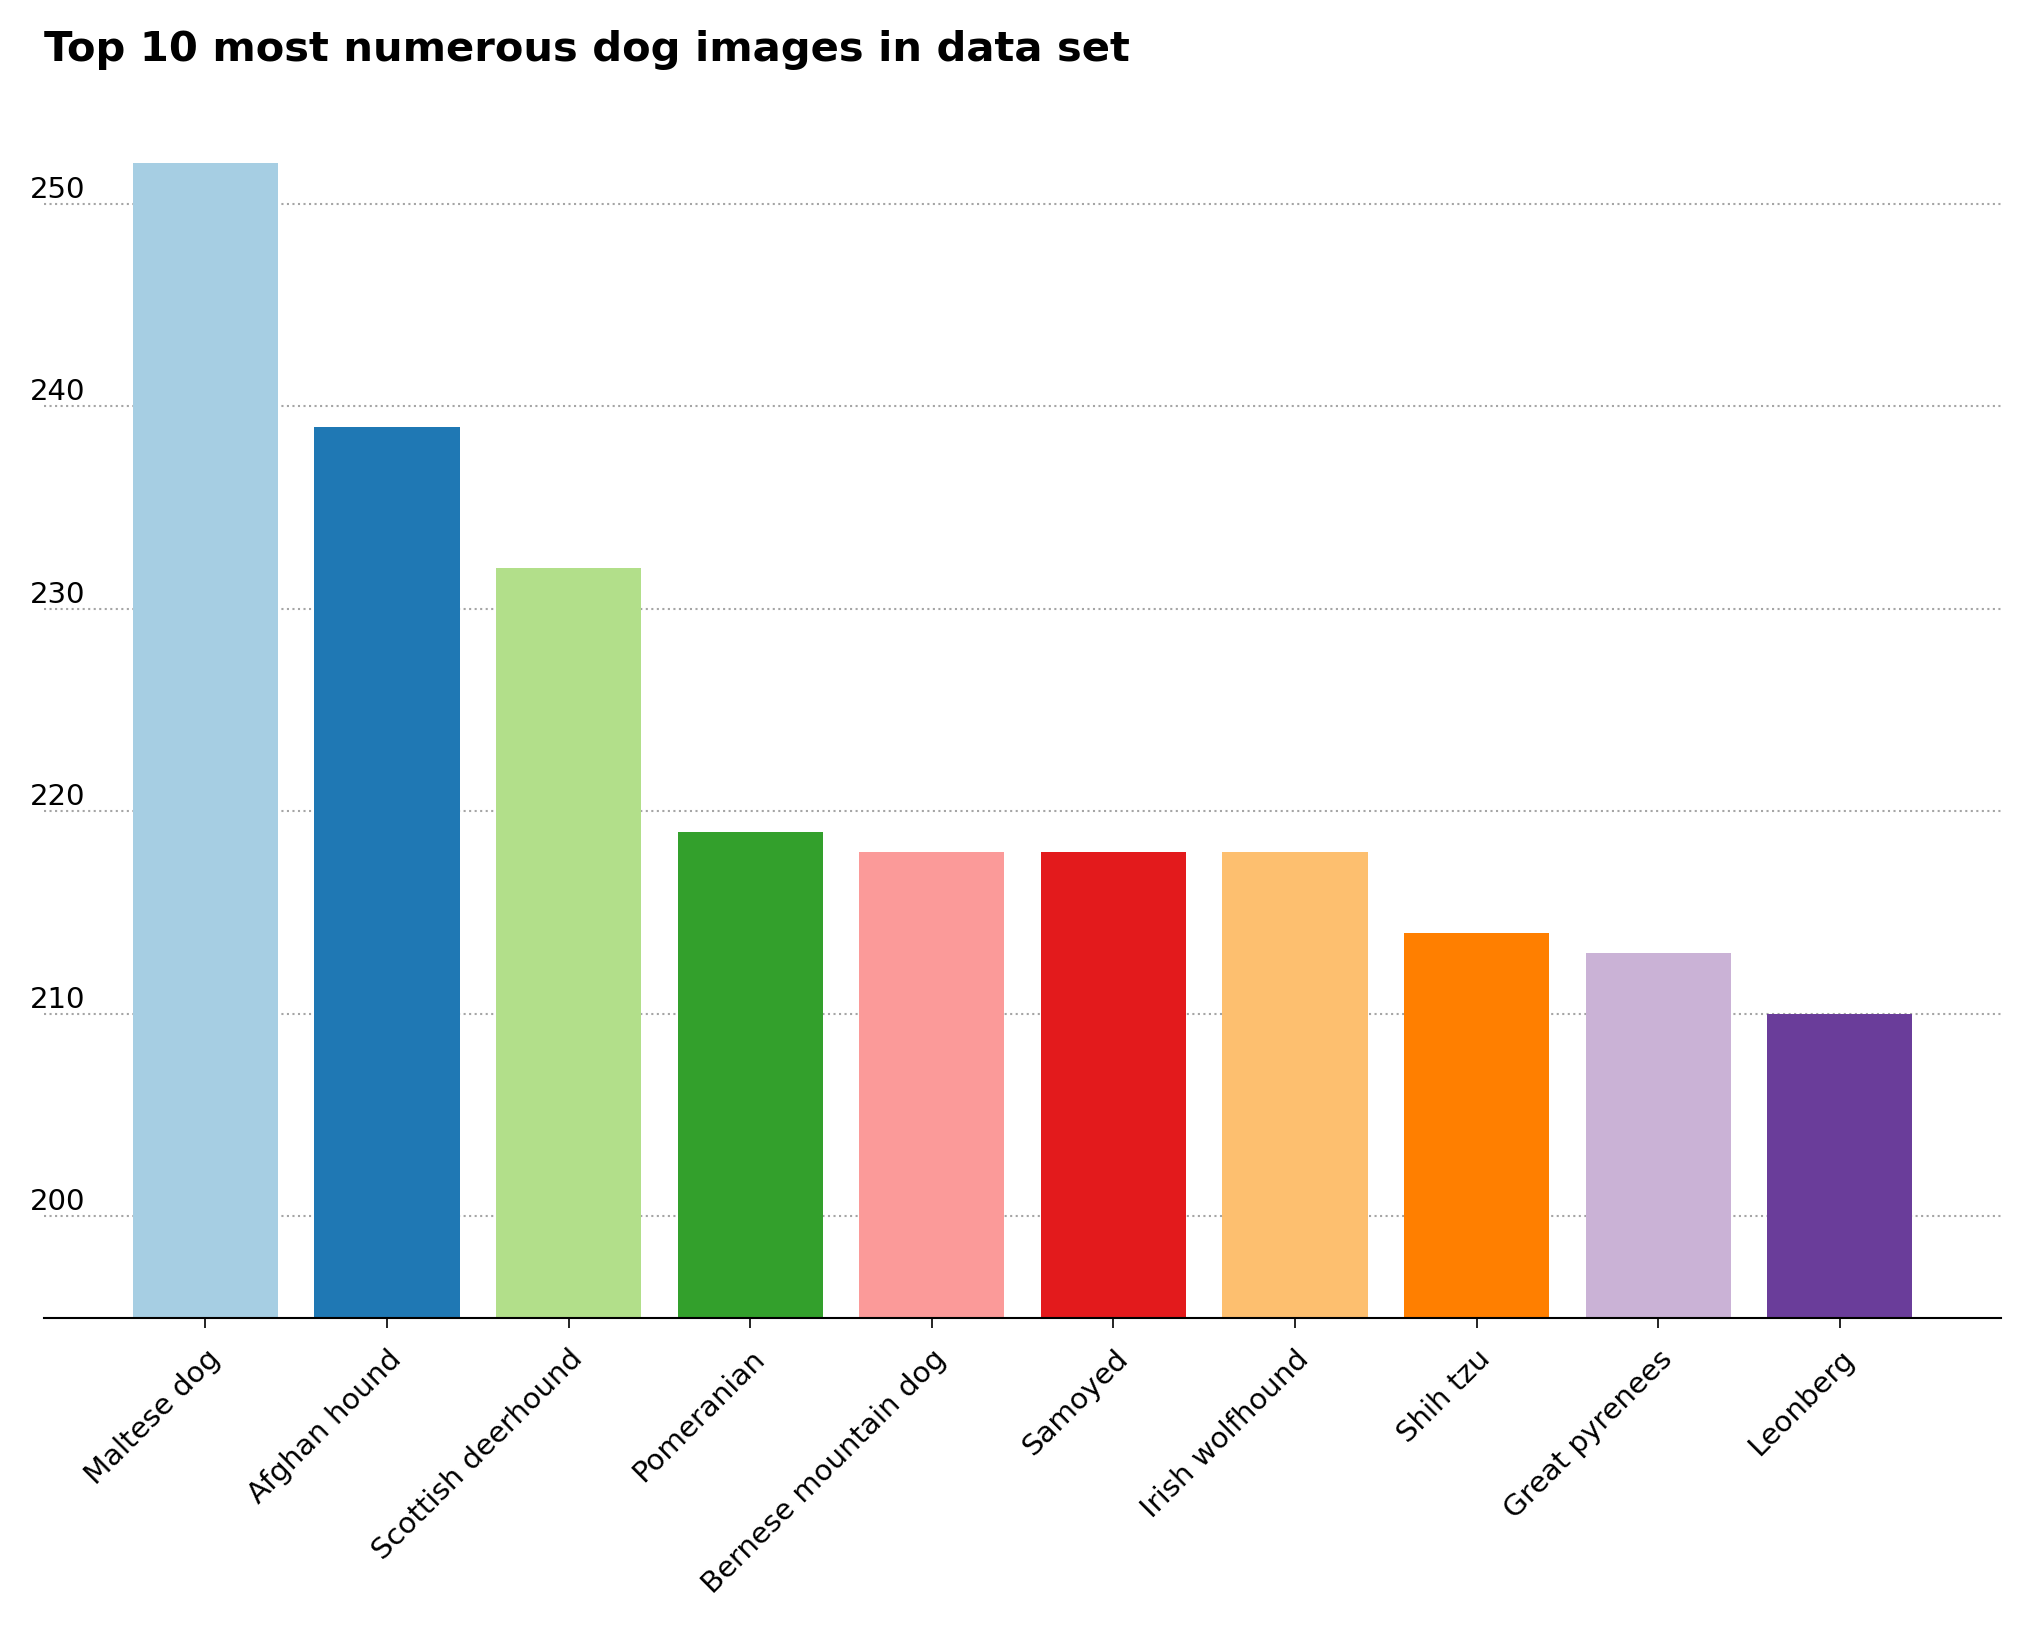

In [10]:
fig, ax = plt.subplots()
ax.bar(breed_sr.index[:top_num], breed_sr.values[:top_num], color=colors,)
plt.setp(ax.get_xticklabels(), ha='right', rotation_mode='anchor', rotation=45)
ax.set_xticks(range(top_num))
ax.set_xticklabels(custom_labels)
ax.set_ylim([195, 255])
ax.set_title(f'Top {top_num} most numerous dog images in data set');

## Data selection

In [20]:
# modified from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook
Path.mkdir(Path.cwd() / 'data/processed', exist_ok=True)
for breed_dir in breed_dir_list:
    Path.mkdir(Path.cwd() / 'data/processed' / breed_dir, exist_ok=True)
print(f'''Created {len(os.listdir('data/processed'))} folders to store cropped images of the different breeds.''')

Created 120 folders to store cropped images of the different breeds.


In [21]:
t0 = time()
for breed_dir in os.listdir('data/processed/'):
    counter = 0
    for breed_file in os.listdir(f'data/raw/Annotation/{breed_dir}'):
        img = Image.open(f'data/raw/Images/{breed_dir}/{breed_file}.jpg')
        tree = ET.parse(f'data/raw/Annotation/{breed_dir}/{breed_file}')
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/processed/' + breed_dir + '/' + breed_file + '.jpg')
        counter += 1
    print(f'Saved {counter} images in {breed_dir} folder.')
print(f'Time elapsed: {round(time()-t0, 2)} seconds.')

Saved 183 images in n02097658-silky_terrier folder.
Saved 232 images in n02092002-Scottish_deerhound folder.
Saved 167 images in n02099849-Chesapeake_Bay_retriever folder.
Saved 188 images in n02091244-Ibizan_hound folder.
Saved 157 images in n02095314-wire-haired_fox_terrier folder.
Saved 200 images in n02091831-Saluki folder.
Saved 159 images in n02102318-cocker_spaniel folder.
Saved 154 images in n02104365-schipperke folder.
Saved 151 images in n02090622-borzoi folder.
Saved 181 images in n02113023-Pembroke folder.
Saved 154 images in n02105505-komondor folder.
Saved 155 images in n02093256-Staffordshire_bullterrier folder.
Saved 159 images in n02113799-standard_poodle folder.
Saved 150 images in n02109961-Eskimo_dog folder.
Saved 157 images in n02089973-English_foxhound folder.
Saved 150 images in n02099601-golden_retriever folder.
Saved 202 images in n02095889-Sealyham_terrier folder.
Saved 185 images in n02085782-Japanese_spaniel folder.
Saved 154 images in n02097047-miniature_sc